# Chapter 11. Training Deep Neural Networks

Project Goal: vanishing gradients, exploding gardients, pre-training, optimizer, normalization

# 梯度消失(Vanishing Gradients) 與 梯度爆炸(Exploding Gradients)

* 梯度消失：在神經網絡反向傳播中，當梯度從後往前傳時，梯度不斷減小，最後變為零，此時，淺層的神經網絡權重得不到更新，那麼前面隱藏層的學習速率低於後面隱藏層的學習速率，即隨著隱藏層數目的增加，分類準確率反而下降了。
* 梯度爆炸：權重將隨著層數的增加以指數形式越變越大，越是靠近淺層(靠近input層)的權重變動會越來越大，當權值過大時，神經網絡中淺層比深層的梯度變化更快，就會引起梯度爆炸問題。

處理方法：將各層的連結權重初始值設為隨機值, 稱為 Xavier初始化 / Glorot初始化

# 不飽和的觸發函數 (Nonsaturating Activation Functions)

造成梯度不穩定的原因, 有時候是因為選擇了不好的觸發函數
* 例如：dying ReLU, 是指有些神經元的權重被調整成無論如何都會輸出0, 那就代表他死掉了。
* 解決方法之一是利用 leaky ReLU, 設定一個很小的洩漏值, 可以確保他不會完全死亡, 有機率再醒過來 (詳細見p. 327)
* 除了 leaky ReLU 之外, 還有更多的方式, 例如：ELU, SELU...等, 詳見p.329

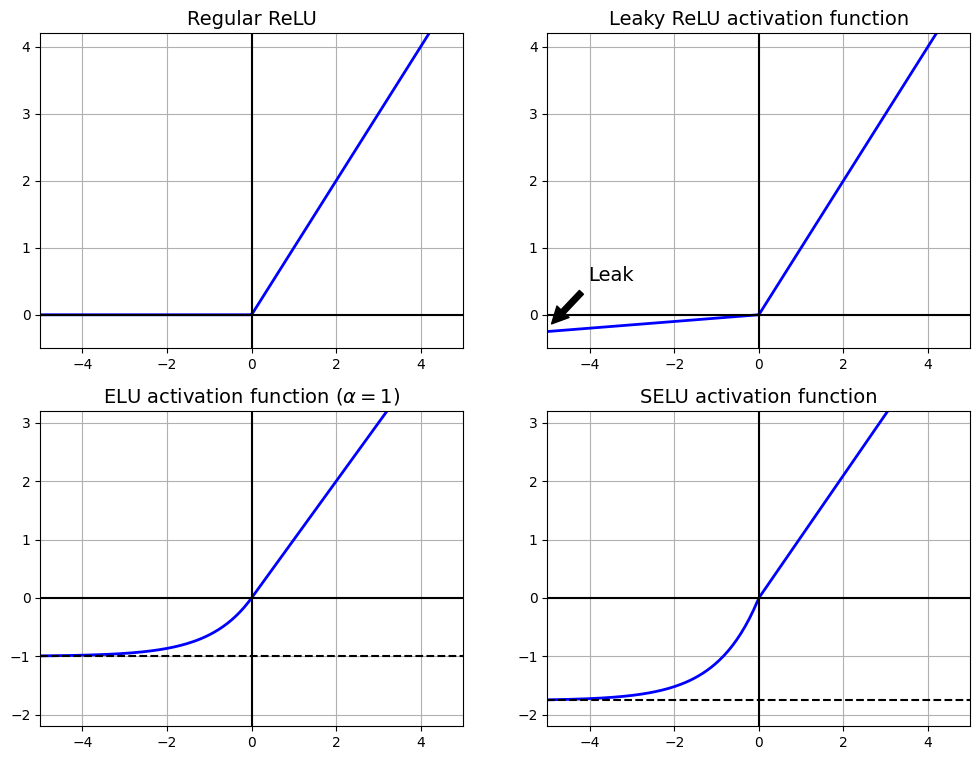

In [2]:
import numpy as np
import matplotlib.pyplot as plt

def relu(z):
    return np.maximum(z, 0)

def leaky_relu(z, alpha=0.01):
    return np.maximum(alpha*z, z)

def elu(z, alpha=1):
    return np.where(z < 0, alpha * (np.exp(z) - 1), z)

from scipy.special import erfc
# alpha and scale to self normalize with mean 0 and standard deviation 1
# (see equation 14 in the paper):
alpha_0_1 = -np.sqrt(2 / np.pi) / (erfc(1/np.sqrt(2)) * np.exp(1/2) - 1)
scale_0_1 = (1 - erfc(1 / np.sqrt(2)) * np.sqrt(np.e)) * np.sqrt(2 * np.pi) * (2 * erfc(np.sqrt(2))*np.e**2 + np.pi*erfc(1/np.sqrt(2))**2*np.e - 2*(2+np.pi)*erfc(1/np.sqrt(2))*np.sqrt(np.e)+np.pi+2)**(-1/2)
def selu(z, scale=scale_0_1, alpha=alpha_0_1):
    return scale * elu(z, alpha)

z = np.linspace(-5, 5, 200)
plt.figure(figsize=(12, 9))

plt.subplot(221)
plt.plot(z, relu(z, ), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([0, 0], [-0.5, 4.2], 'k-')
plt.grid(True)
plt.title("Regular ReLU", fontsize=14)
plt.axis([-5, 5, -0.5, 4.2])

plt.subplot(222)
plt.plot(z, leaky_relu(z, 0.05), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([0, 0], [-0.5, 4.2], 'k-')
plt.grid(True)
props = dict(facecolor='black', shrink=0.1)
plt.annotate('Leak', xytext=(-3.5, 0.5), xy=(-5, -0.2), arrowprops=props, fontsize=14, ha="center")
plt.title("Leaky ReLU activation function", fontsize=14)
plt.axis([-5, 5, -0.5, 4.2])

plt.subplot(223)
plt.plot(z, elu(z), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [-1, -1], 'k--')
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.grid(True)
plt.title(r"ELU activation function ($\alpha=1$)", fontsize=14)
plt.axis([-5, 5, -2.2, 3.2])

plt.subplot(224)
plt.plot(z, selu(z), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [-1.758, -1.758], 'k--')
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.grid(True)
plt.title("SELU activation function", fontsize=14)
plt.axis([-5, 5, -2.2, 3.2])

plt.show()

# Batch Normalization (批次正規化)

雖然使用上述的 ReLU 變體可以在訓練初期大幅降低梯度消失或梯度爆炸的現象, 但無法保證訓練中期不會發生 -> 解決方法是批次正規化 (Batch Normalization, BN)

在每個隱藏層的觸發函數之前或之後加上一層 Batch Normalization, 讓模型學習各個階層的輸入之最佳尺度與均值, 詳細原理在p. 330~333

In [3]:
# 方法一. BN層加在隱藏層之後
import keras

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]), 
    keras.layers.BatchNormalization(),
    keras.layers.Dense(300, activation="relu"), 
    keras.layers.BatchNormalization(),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(10, activation="softmax")
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 batch_normalization (Batch  (None, 784)               3136      
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 300)               235500    
                                                                 
 batch_normalization_1 (Bat  (None, 300)               1200      
 chNormalization)                                                
                                                                 
 dense_1 (Dense)             (None, 100)               30100     
                                                                 
 batch_normalization_2 (Bat  (None, 100)               4

In [11]:
# 方法二. BN層加在隱藏層之前, 就要將上一層的bias移除
keras.backend.clear_session()

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=(28, 28)),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(300, kernel_initializer="he_normal", use_bias=False),
    keras.layers.BatchNormalization(),
    keras.layers.Activation("elu"), 
    keras.layers.Dense(100, kernel_initializer="he_normal", use_bias=False),
    keras.layers.BatchNormalization(),
    keras.layers.Activation("elu"),
    keras.layers.Dense(10, activation="softmax")
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 batch_normalization (Batch  (None, 784)               3136      
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 300)               235200    
                                                                 
 batch_normalization_1 (Bat  (None, 300)               1200      
 chNormalization)                                                
                                                                 
 activation (Activation)     (None, 300)               0         
                                                                 
 dense_1 (Dense)             (None, 100)               3

# Gradient Clipping (梯度修剪)

另一種處理梯度爆炸的方法是在反向傳播的時候修剪梯度, 讓他不會超過某個閾值

In [ ]:
optimizer = keras.optimizers.SGD(clipvalue=1.0)   # 目標向量的每一個值
optimizer = keras.optimizers.SGD(clipnorm=1.0)    # 目標向量的l2 norm
model.compile(loss="mse", optimizer=optimizer)

# 重復使用 pretrained Layers

利用處理類似任務的模型之低層, 稱為 遷移學習(transfer learning)
* 可以先凍結所有重復使用的階層(讓他們權重無法被訓練), 看看表現如何
* 再試著解凍一兩層, 看看是否改善, 訓練資料愈多, 可以解凍更多層
* 若效果仍然不好, 可以試著移除或替換上層的一些隱藏層

# 範例：以 Keras 進行遷移學習

In [4]:
import tensorflow as tf
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train_full = X_train_full / 255.0
X_test = X_test / 255.0
X_valid, X_train = X_train_full[:5000], X_train_full[5000:]
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]

# 假設先把X_train分成兩組
# X_train_A是除了類別5及類別6之外的其他所有資料, X_train_A.shape = (43986, 28, 28)
# X_train_B是屬於類別5及類別6的前200張照片, 要做二元分類, X_train_B.shape = (200, 28, 28)
# 我們的目標是重複利用A的模型去訓練B

def split_dataset(X, y):
    y_5_or_6 = (y == 5) | (y == 6)
    y_A = y[~y_5_or_6]
    y_A[y_A > 6] -= 2            # 因為沒有5, 6了, 所以把7, 8, 9 移到 5, 6, 7
    y_B = (y[y_5_or_6] == 6).astype(np.float32) # binary classification task: is it a shirt (class 6)?
    return ((X[~y_5_or_6], y_A),
            (X[y_5_or_6], y_B))

(X_train_A, y_train_A), (X_train_B, y_train_B) = split_dataset(X_train, y_train)
(X_valid_A, y_valid_A), (X_valid_B, y_valid_B) = split_dataset(X_valid, y_valid)
(X_test_A, y_test_A), (X_test_B, y_test_B) = split_dataset(X_test, y_test)
X_train_B = X_train_B[:200]
y_train_B = y_train_B[:200]

tf.random.set_seed(42)
np.random.seed(42)

In [14]:
model_A = keras.models.Sequential()
model_A.add(keras.layers.Flatten(input_shape=[28, 28]))
for n_hidden in (300, 100, 50, 50, 50):
    model_A.add(keras.layers.Dense(n_hidden, activation="selu"))
model_A.add(keras.layers.Dense(8, activation="softmax"))

model_A.compile(loss="sparse_categorical_crossentropy",
                optimizer=keras.optimizers.SGD(learning_rate=1e-3),
                metrics=["accuracy"])

history = model_A.fit(X_train_A, y_train_A, epochs=20,
                      validation_data=(X_valid_A, y_valid_A))

model_A.save("my_model_A.h5")

Epoch 1/20
1375/1375 [==============================] - 2s 1ms/step - loss: 0.6218 - accuracy: 0.8008 - val_loss: 0.3999 - val_accuracy: 0.8627
Epoch 2/20
1375/1375 [==============================] - 2s 1ms/step - loss: 0.3639 - accuracy: 0.8736 - val_loss: 0.3303 - val_accuracy: 0.8844
Epoch 3/20
1375/1375 [==============================] - 2s 1ms/step - loss: 0.3245 - accuracy: 0.8861 - val_loss: 0.3054 - val_accuracy: 0.8956
Epoch 4/20
1375/1375 [==============================] - 2s 1ms/step - loss: 0.3037 - accuracy: 0.8950 - val_loss: 0.2924 - val_accuracy: 0.9001
Epoch 5/20
1375/1375 [==============================] - 2s 1ms/step - loss: 0.2897 - accuracy: 0.8996 - val_loss: 0.2811 - val_accuracy: 0.9051
Epoch 6/20
1375/1375 [==============================] - 2s 1ms/step - loss: 0.2793 - accuracy: 0.9038 - val_loss: 0.2752 - val_accuracy: 0.9061
Epoch 7/20
1375/1375 [==============================] - 2s 1ms/step - loss: 0.2704 - accuracy: 0.9069 - val_loss: 0.2691 - val_accuracy:

/Users/chenyanting/Desktop/Machine Learning Study/my_env/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [15]:
model_B = keras.models.Sequential()
model_B.add(keras.layers.Flatten(input_shape=[28, 28]))
for n_hidden in (300, 100, 50, 50, 50):
    model_B.add(keras.layers.Dense(n_hidden, activation="selu"))
model_B.add(keras.layers.Dense(1, activation="sigmoid"))

model_B.compile(loss="binary_crossentropy",
                optimizer=keras.optimizers.SGD(learning_rate=1e-3),
                metrics=["accuracy"])

history = model_B.fit(X_train_B, y_train_B, epochs=20,
                      validation_data=(X_valid_B, y_valid_B))

model_B.summary()

Epoch 1/20
7/7 [==============================] - 0s 18ms/step - loss: 0.4434 - accuracy: 0.8350 - val_loss: 0.4351 - val_accuracy: 0.8327
Epoch 2/20
7/7 [==============================] - 0s 7ms/step - loss: 0.3692 - accuracy: 0.8800 - val_loss: 0.3693 - val_accuracy: 0.8712
Epoch 3/20
7/7 [==============================] - 0s 7ms/step - loss: 0.3153 - accuracy: 0.9000 - val_loss: 0.3223 - val_accuracy: 0.8874
Epoch 4/20
7/7 [==============================] - 0s 7ms/step - loss: 0.2755 - accuracy: 0.9300 - val_loss: 0.2871 - val_accuracy: 0.9108
Epoch 5/20
7/7 [==============================] - 0s 7ms/step - loss: 0.2427 - accuracy: 0.9400 - val_loss: 0.2595 - val_accuracy: 0.9209
Epoch 6/20
7/7 [==============================] - 0s 7ms/step - loss: 0.2172 - accuracy: 0.9450 - val_loss: 0.2374 - val_accuracy: 0.9361
Epoch 7/20
7/7 [==============================] - 0s 7ms/step - loss: 0.1972 - accuracy: 0.9500 - val_loss: 0.2193 - val_accuracy: 0.9452
Epoch 8/20
7/7 [=================

In [22]:
model_A = keras.models.load_model("my_model_A.h5")
# 因為 model_B_on_A 和 model_A 會使用到相同的階層, 在訓練一者時會影響到另一者
# 所以正確來說應該是要以 model_A 的 clone 來製造出 model_B_on_A 兩者才會獨立
model_A_clone = keras.models.clone_model(model_A)
model_A_clone.set_weights(model_A.get_weights())
model_B_on_A = keras.models.Sequential(model_A_clone.layers[:-1])
# 此時 model_B_on_A 是 model_A 除了輸出層以外的所有階層
model_B_on_A.add(keras.layers.Dense(1, activation="sigmoid"))

# 複製完後, 先以凍結隱藏層的模型去訓練一陣子(下面是epochs=4)
for layer in model_B_on_A.layers[:-1]:
    layer.trainable = False

model_B_on_A.compile(loss="binary_crossentropy", 
                     optimizer=keras.optimizers.SGD(learning_rate=1e-3), 
                     metrics=["accuracy"])

history = model_B_on_A.fit(X_train_B, y_train_B, epochs=4,
                           validation_data=(X_valid_B, y_valid_B))

# 接著再解凍隱藏層, 繼續訓練(下面是epochs=16)
for layers in model_B_on_A.layers[:-1]:
    layer.trainable = True

model_B_on_A.compile(loss="binary_crossentropy",
                     optimizer=keras.optimizers.SGD(learning_rate=1e-3),
                     metrics=["accuracy"])

history = model_B_on_A.fit(X_train_B, y_train_B, epochs=16,
                           validation_data=(X_valid_B, y_valid_B))

# 最後來評估模型效果
print("Directly trained B:", model_B.evaluate(X_test_B, y_test_B))    # 回傳的是[loss, accuracy]
print("Using transfer learning:", model_B_on_A.evaluate(X_test_B, y_test_B))
# 其實結果理論上會進步耶, 怎麼搞的......

Epoch 1/4
7/7 [==============================] - 0s 17ms/step - loss: 0.9115 - accuracy: 0.5900 - val_loss: 0.8917 - val_accuracy: 0.6045
Epoch 2/4
7/7 [==============================] - 0s 7ms/step - loss: 0.8533 - accuracy: 0.6250 - val_loss: 0.8436 - val_accuracy: 0.6166
Epoch 3/4
7/7 [==============================] - 0s 6ms/step - loss: 0.8039 - accuracy: 0.6400 - val_loss: 0.7985 - val_accuracy: 0.6308
Epoch 4/4
7/7 [==============================] - 0s 7ms/step - loss: 0.7576 - accuracy: 0.6450 - val_loss: 0.7518 - val_accuracy: 0.6481


Epoch 1/16
7/7 [==============================] - 0s 17ms/step - loss: 0.6869 - accuracy: 0.6600 - val_loss: 0.6469 - val_accuracy: 0.6734
Epoch 2/16
7/7 [==============================] - 0s 6ms/step - loss: 0.5851 - accuracy: 0.7050 - val_loss: 0.5692 - val_accuracy: 0.6937
Epoch 3/16
7/7 [==============================] - 0s 6ms/step - loss: 0.5106 - accuracy: 0.7250 - val_loss: 0.5042 - val_accuracy: 0.7211
Epoch 4/16
7/7 [==============================] - 0s 6ms/step - loss: 0.4486 - accuracy: 0.7400 - val_loss: 0.4425 - val_accuracy: 0.7505
Epoch 5/16
7/7 [==============================] - 0s 7ms/step - loss: 0.3904 - accuracy: 0.8000 - val_loss: 0.3919 - val_accuracy: 0.7870
Epoch 6/16
7/7 [==============================] - 0s 6ms/step - loss: 0.3432 - accuracy: 0.8350 - val_loss: 0.3519 - val_accuracy: 0.8185
Epoch 7/16
7/7 [==============================] - 0s 7ms/step - loss: 0.3057 - accuracy: 0.8700 - val_loss: 0.3171 - val_accuracy: 0.8580
Epoch 8/16
7/7 [=================

# 更快速的優化法 Optimizers

以下是一些比一般的 SGD optimizer 更好的優化法：
1. 動量優化 (momentum optimization): 比起有規律的一步一步跳, 動量優化比較像是把球用滾的滾下斜坡, 利用梯度來加速 (詳見p.343, 344)

In [ ]:
# Momentum Optimization
optimizer = keras.optimizers.SGD(learning_rate=0.001, momentum=0.9)
# 一般來說, momentum 設為 0.9 都能有不錯的效果

2. Nesterov 加速梯度法 (NAG): 在動量優化的基礎上改進, 讓每一次要走下一步前, 都先往梯度方向移動一小段距離, 再由該位置開始計算新的梯度, 這樣可以再加速一些 (p. 344, 345)

In [ ]:
# Nesterov Accelerated Gradient (NAG)
optimizer = keras.optimizers.SGD(learning_rate=0.001, momentum=0.9, nesterov=True)

3. AdaGrad: 隨著梯度大小去動態調整 learning rate, 可以讓結果的更新更直接地指向全域最佳值, 但他的問題在於learning rate常常下降太快, 以致於還沒到全域最佳值就停止了, 所以不適合用於訓練神經網路, 但可以用在線性回歸等簡單的任務 (p. 345~347)

In [ ]:
# AdaGrad
optimizer = keras.optimizers.Adagrad(learning_rate=0.001)

4. RMSProp: AdaGrad 的問題在於不斷累積梯度, 所以速度下降太快; 而 RMSProp 改成只會累積最近幾次迭代的梯度, 就可以修正一些了 (p.347)

In [ ]:
# RMSProp
optimizer = keras.optimizers.RMSprop(learning_rate=0.001, rho=0.9)
# rho 是 衰減率(beta), 通常被設為0.9

5. Adam (Adaptive Moment Estimation): 結合動量優化與RMSProp, 通常效果會是上述優化法當中最好的

In [ ]:
# Adam
optimizer = keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)
# beta_1 與 beta_2 通常會被設為 0.9 與 0.999

6. AdaMax: 通常會比 Adam 穩定, 但表現不會比較好

In [ ]:
# AdaMax
optimizer = keras.optimizers.Adamax(learning_rate=0.001, beta_1=0.9, beta_2=0.999)

7. Nadam: Adam 加上 Nesterov, 收斂速度通常比 Adam 快, 效果也通常比 Adam 好

In [ ]:
# Nadam
optimizer = keras.optimizers.Nadam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)

# 各種優化法的比較

類別                收斂速度     收斂品質
SGD                  *          ***
SGD + Momentum       **         ***
SGD + Nesterov       **         ***
AdaGrad              ***        *
RMSProp              ***        ** or ***
Adam                 ***        ** or ***
AdaMax               ***        ** or ***
Nadam                ***        ** or ***

# Learning Rate Scheduling

* learning rate 太高, 會導致模型在最佳值附近振盪, 不會停下來
* learning rate 太低, 會導致訓練過程花費大量的時間
* 所以最好的方法是：一開始先用較大的 learning rate, 再逐步調降

1. Power Scheduling: lr = lr0 / (1 + step / s)**c, s=1/decay

Epoch 1/25
1719/1719 [==============================] - 2s 1ms/step - loss: 0.4909 - accuracy: 0.8257 - val_loss: 0.4015 - val_accuracy: 0.8612
Epoch 2/25
1719/1719 [==============================] - 2s 1ms/step - loss: 0.3834 - accuracy: 0.8642 - val_loss: 0.3721 - val_accuracy: 0.8724
Epoch 3/25
1719/1719 [==============================] - 2s 1ms/step - loss: 0.3514 - accuracy: 0.8756 - val_loss: 0.3731 - val_accuracy: 0.8708
Epoch 4/25
1719/1719 [==============================] - 2s 1ms/step - loss: 0.3305 - accuracy: 0.8821 - val_loss: 0.3480 - val_accuracy: 0.8784
Epoch 5/25
1719/1719 [==============================] - 2s 1ms/step - loss: 0.3151 - accuracy: 0.8880 - val_loss: 0.3435 - val_accuracy: 0.8798
Epoch 6/25
1719/1719 [==============================] - 2s 1ms/step - loss: 0.3013 - accuracy: 0.8924 - val_loss: 0.3386 - val_accuracy: 0.8856
Epoch 7/25
1719/1719 [==============================] - 2s 1ms/step - loss: 0.2914 - accuracy: 0.8962 - val_loss: 0.3335 - val_accuracy:

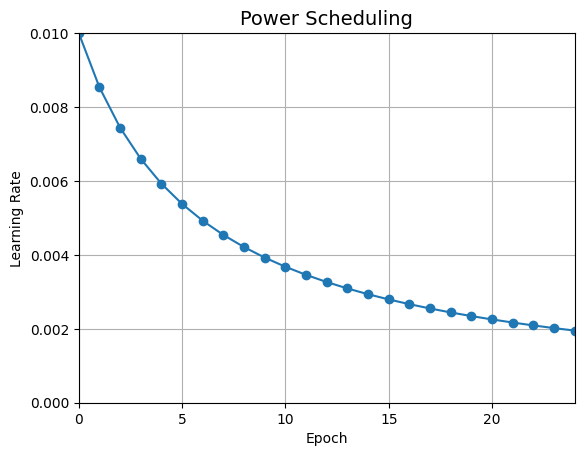

In [9]:
# 加上 decay 即可, 而 c 預設為 1
optimizer = keras.optimizers.legacy.SGD(learning_rate=0.01, decay=1e-4)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]), 
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])

model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

n_epochs = 25
pixel_means = X_train.mean(axis=0, keepdims=True)
pixel_stds = X_train.std(axis=0, keepdims=True)
X_train_scaled = (X_train - pixel_means) / pixel_stds
X_valid_scaled = (X_valid - pixel_means) / pixel_stds
X_test_scaled = (X_test - pixel_means) / pixel_stds

history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))

import math
learning_rate = 0.01
decay = 1e-4
batch_size = 32
n_steps_per_epoch = math.ceil(len(X_train) / batch_size)
epochs = np.arange(n_epochs)
lrs = learning_rate / (1 + decay * epochs * n_steps_per_epoch)

plt.plot(epochs, lrs, "o-")
plt.axis([0, n_epochs - 1, 0, 0.01])
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.title("Power Scheduling", fontsize=14)
plt.grid(True)
plt.show()

2. Exponential Scheduling: lr = lr0 * 0.1**(epoch / s)

Epoch 1/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.8572 - accuracy: 0.7565 - val_loss: 1.2098 - val_accuracy: 0.6186 - lr: 0.0100
Epoch 2/25
1719/1719 [==============================] - 4s 2ms/step - loss: 0.7519 - accuracy: 0.7807 - val_loss: 0.6799 - val_accuracy: 0.8038 - lr: 0.0089
Epoch 3/25
1719/1719 [==============================] - 4s 2ms/step - loss: 0.7004 - accuracy: 0.7943 - val_loss: 0.8586 - val_accuracy: 0.6948 - lr: 0.0079
Epoch 4/25
1719/1719 [==============================] - 4s 2ms/step - loss: 0.5909 - accuracy: 0.8256 - val_loss: 0.5192 - val_accuracy: 0.8466 - lr: 0.0071
Epoch 5/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.5447 - accuracy: 0.8337 - val_loss: 0.5442 - val_accuracy: 0.8424 - lr: 0.0063
Epoch 6/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.5123 - accuracy: 0.8465 - val_loss: 0.8698 - val_accuracy: 0.8480 - lr: 0.0056
Epoch 7/25
1719/1719 [==============================] - 4s

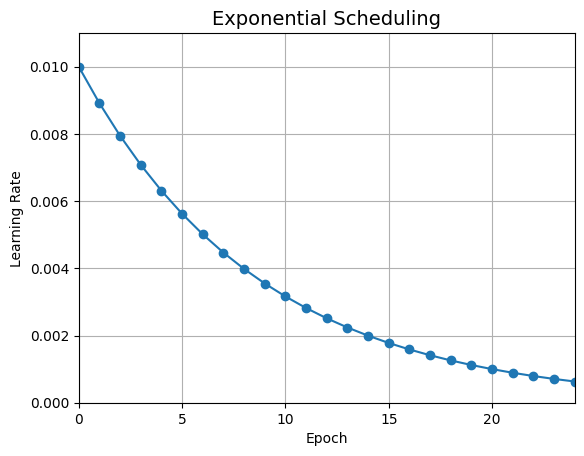

In [26]:
def exponential_decay_fn(epoch):
    return 0.01 * 0.1**(epoch / 20)

def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1**(epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(lr0=0.01, s=20)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 25
lr_scheduler = keras.callbacks.LearningRateScheduler(exponential_decay_fn)
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid),
                    callbacks=[lr_scheduler])

plt.plot(history.epoch, history.history["lr"], "o-")
plt.axis([0, n_epochs - 1, 0, 0.011])
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.title("Exponential Scheduling", fontsize=14)
plt.grid(True)
plt.show()

3. Piecewise Constant Scheduling: 自行設定前幾次跟後幾次epoch的lr

Epoch 1/25
1719/1719 [==============================] - 4s 2ms/step - loss: 0.9013 - accuracy: 0.7402 - val_loss: 1.2589 - val_accuracy: 0.6448 - lr: 0.0100
Epoch 2/25
1719/1719 [==============================] - 4s 2ms/step - loss: 0.8712 - accuracy: 0.7371 - val_loss: 0.8849 - val_accuracy: 0.7260 - lr: 0.0100
Epoch 3/25
1719/1719 [==============================] - 4s 2ms/step - loss: 0.9312 - accuracy: 0.7265 - val_loss: 1.5834 - val_accuracy: 0.5840 - lr: 0.0100
Epoch 4/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.8138 - accuracy: 0.7437 - val_loss: 0.7105 - val_accuracy: 0.7824 - lr: 0.0100
Epoch 5/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.8581 - accuracy: 0.7471 - val_loss: 0.6697 - val_accuracy: 0.8022 - lr: 0.0100
Epoch 6/25
1719/1719 [==============================] - 4s 2ms/step - loss: 0.5314 - accuracy: 0.8403 - val_loss: 0.5457 - val_accuracy: 0.8544 - lr: 0.0050
Epoch 7/25
1719/1719 [==============================] - 4s

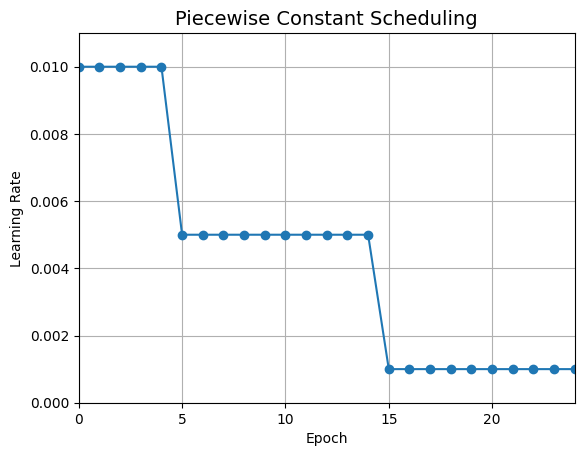

In [27]:
def piecewise_constant_fn(epoch):
    if epoch < 5:
        return 0.01
    elif epoch < 15:
        return 0.005
    else:
        return 0.001
    
def piecewise_constant(boundaries, values):
    boundaries = np.array([0] + boundaries)
    values = np.array(values)
    def piecewise_constant_fn(epoch):
        return values[np.argmax(boundaries > epoch) - 1]
    return piecewise_constant_fn

piecewise_constant_fn = piecewise_constant([5, 15], [0.01, 0.005, 0.001])
lr_scheduler = keras.callbacks.LearningRateScheduler(piecewise_constant_fn)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 25
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid),
                    callbacks=[lr_scheduler])

plt.plot(history.epoch, [piecewise_constant_fn(epoch) for epoch in history.epoch], "o-")
plt.axis([0, n_epochs - 1, 0, 0.011])
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.title("Piecewise Constant Scheduling", fontsize=14)
plt.grid(True)
plt.show()

4. Performance Scheduling: 每n步就評量 validation loss, 當它停止下降時便將 learning rate 降低λ倍

Epoch 1/25
1719/1719 [==============================] - 3s 1ms/step - loss: 0.5920 - accuracy: 0.8067 - val_loss: 0.4647 - val_accuracy: 0.8542 - lr: 0.0200
Epoch 2/25
1719/1719 [==============================] - 2s 1ms/step - loss: 0.4971 - accuracy: 0.8399 - val_loss: 0.5538 - val_accuracy: 0.8384 - lr: 0.0200
Epoch 3/25
1719/1719 [==============================] - 2s 1ms/step - loss: 0.5192 - accuracy: 0.8401 - val_loss: 0.5053 - val_accuracy: 0.8544 - lr: 0.0200
Epoch 4/25
1719/1719 [==============================] - 2s 1ms/step - loss: 0.5008 - accuracy: 0.8485 - val_loss: 0.5241 - val_accuracy: 0.8464 - lr: 0.0200
Epoch 5/25
1719/1719 [==============================] - 2s 1ms/step - loss: 0.5102 - accuracy: 0.8510 - val_loss: 0.5137 - val_accuracy: 0.8392 - lr: 0.0200
Epoch 6/25
1719/1719 [==============================] - 2s 1ms/step - loss: 0.5138 - accuracy: 0.8533 - val_loss: 0.7285 - val_accuracy: 0.8318 - lr: 0.0200
Epoch 7/25
1719/1719 [==============================] - 2s

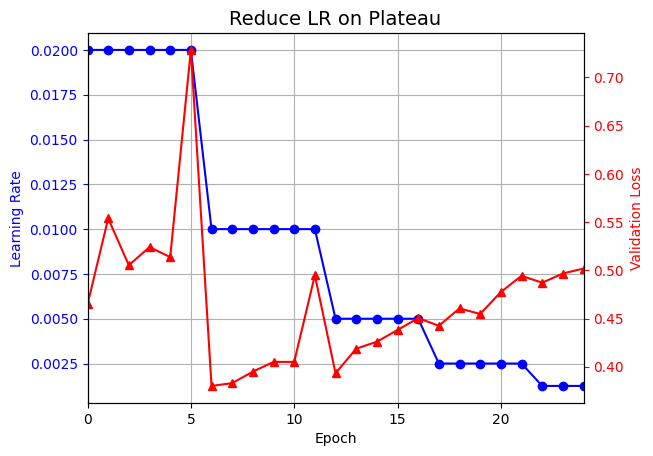

In [29]:
tf.random.set_seed(42)
np.random.seed(42)

lr_scheduler = keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=5)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]), 
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])

optimizer = keras.optimizers.legacy.SGD(learning_rate=0.02, momentum=0.9)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
n_epochs = 25
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid),
                    callbacks=[lr_scheduler])

plt.plot(history.epoch, history.history["lr"], "bo-")
plt.xlabel("Epoch")
plt.ylabel("Learning Rate", color='b')
plt.tick_params('y', colors='b')
plt.gca().set_xlim(0, n_epochs - 1)
plt.grid(True)

ax2 = plt.gca().twinx()
ax2.plot(history.epoch, history.history["val_loss"], "r^-")
ax2.set_ylabel('Validation Loss', color='r')
ax2.tick_params('y', colors='r')

plt.title("Reduce LR on Plateau", fontsize=14)
plt.show()

5. tf.keras 內建的 learning rate scheduling

In [30]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]), 
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])

s = 20 * len(X_train) // 32          # 在20個epoch裡面的步數(batch_size=32)
learning_rate = keras.optimizers.schedules.ExponentialDecay(0.01, s, 0.1)
optimizer = keras.optimizers.SGD(learning_rate)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
n_epochs = 25
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/25
1719/1719 [==============================] - 2s 1ms/step - loss: 0.4876 - accuracy: 0.8286 - val_loss: 0.4007 - val_accuracy: 0.8592
Epoch 2/25
1719/1719 [==============================] - 2s 1ms/step - loss: 0.3796 - accuracy: 0.8652 - val_loss: 0.3703 - val_accuracy: 0.8694
Epoch 3/25
1719/1719 [==============================] - 2s 1ms/step - loss: 0.3456 - accuracy: 0.8762 - val_loss: 0.3749 - val_accuracy: 0.8684
Epoch 4/25
1719/1719 [==============================] - 3s 2ms/step - loss: 0.3243 - accuracy: 0.8833 - val_loss: 0.3515 - val_accuracy: 0.8738
Epoch 5/25
1719/1719 [==============================] - 2s 1ms/step - loss: 0.3086 - accuracy: 0.8900 - val_loss: 0.3452 - val_accuracy: 0.8752
Epoch 6/25
1719/1719 [==============================] - 2s 1ms/step - loss: 0.2942 - accuracy: 0.8942 - val_loss: 0.3425 - val_accuracy: 0.8768
Epoch 7/25
1719/1719 [==============================] - 2s 1ms/step - loss: 0.2842 - accuracy: 0.8988 - val_loss: 0.3394 - val_accuracy:

6. 1cycle Scheduling: p.352有介紹, github上有詳細code, 有空可以回來看

# Avoiding Overfitting Through Regularization

1. ℓ1 and ℓ2 regularization

In [5]:
layer = keras.layers.Dense(100, activation="elu",
                           kernel_initializer="he_normal",
                           kernel_regularizer=keras.regularizers.l2(0.01))
# 若是 ℓ1 正則化, 則是 ℓ1(0.1)
# 若兩者都想用, 則是 l1_l2(0.1, 0.01) 

In [10]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="elu",
                       kernel_initializer="he_normal",
                       kernel_regularizer=keras.regularizers.l2(0.01)),
    keras.layers.Dense(100, activation="elu",
                       kernel_initializer="he_normal",
                       kernel_regularizer=keras.regularizers.l2(0.01)),
    keras.layers.Dense(10, activation="softmax",
                       kernel_regularizer=keras.regularizers.l2(0.01))
])

model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 2
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
1719/1719 [==============================] - 5s 3ms/step - loss: 1.5958 - accuracy: 0.8119 - val_loss: 0.7219 - val_accuracy: 0.8306
Epoch 2/2
1719/1719 [==============================] - 4s 2ms/step - loss: 0.7234 - accuracy: 0.8261 - val_loss: 0.6862 - val_accuracy: 0.8368


In [12]:
# 因為我們常常會讓網路的每一層都使用相同的regularizer, 或是讓所有隱藏層都使用相同的activation或initializer
# 可以使用 functools.partial(), 就能將上面的model架構簡化成下面的寫法：

from functools import partial
RegularizedDense = partial(keras.layers.Dense,
                           activation="elu",
                           kernel_initializer="he_normal",
                           kernel_regularizer=keras.regularizers.l2(0.01))

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    RegularizedDense(300),
    RegularizedDense(100),
    RegularizedDense(10, activation="softmax")
])

model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 2
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
1719/1719 [==============================] - 5s 3ms/step - loss: 1.6362 - accuracy: 0.8129 - val_loss: 0.7157 - val_accuracy: 0.8326
Epoch 2/2
1719/1719 [==============================] - 4s 3ms/step - loss: 0.7207 - accuracy: 0.8269 - val_loss: 0.6838 - val_accuracy: 0.8396


2. Dropout: 每次在訓練迭代中, 都有隨機的神經元子集合會被卸除(輸出為0), 通常dropout rate會在10%~50%之間
* dropout雖然會減緩收斂的速度, 但使用得當時通常都能讓模型產生更高的準確率, 因為隨機卸除神經元, 會讓每一次訓練迭代都是獨一無二的神經網路, 也就是說epoch = n, 就代表有n個神經網路在共享權重
* 實務上, 通常只能對最上面三層的神經元執行dropout(當然不行用在輸出層)
* 當模型overfitting時, 可以提升dropout rate; 反之, 若模型underfitting, 可以降低dropout rate
* 許多最先進的結構都只有在最後一個隱藏層之後使用dropout, 如果完全dropout的效果太強烈時可以試試這個

In [14]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dropout(rate=0.2),
    keras.layers.Dense(300, activation="elu", kernel_initializer="he_normal"),
    keras.layers.Dropout(rate=0.2),
    keras.layers.Dense(100, activation="elu", kernel_initializer="he_normal"),
    keras.layers.Dropout(rate=0.2),
    keras.layers.Dense(10, activation="softmax")
])

model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 2
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))

# 由結果可見, 加上dropout後, loss下降, accuracy也上升

Epoch 1/2
1719/1719 [==============================] - 5s 3ms/step - loss: 0.5667 - accuracy: 0.8063 - val_loss: 0.3604 - val_accuracy: 0.8660
Epoch 2/2
1719/1719 [==============================] - 5s 3ms/step - loss: 0.4173 - accuracy: 0.8482 - val_loss: 0.3370 - val_accuracy: 0.8790


3. Alpha Dropout: 比起一般dropout, 多保留了輸入的平均值與標準差 (一般的drpout會破壞自動正規化)

In [ ]:
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.AlphaDropout(rate=0.2),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.AlphaDropout(rate=0.2),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.AlphaDropout(rate=0.2),
    keras.layers.Dense(10, activation="softmax")
])
optimizer = keras.optimizers.SGD(learning_rate=0.01, momentum=0.9, nesterov=True)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
n_epochs = 20
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))

4. Monte Carlo (MC) Dropout: 
* 很多時候模型在沒有dropout的情況下會給出確定性非常高的答案, 但這有時候並不是好事(因為他可能是錯的)
* 故 採用多次dropout結果的平均, 能體現出更準確的機率分佈

In [15]:
tf.random.set_seed(42)
np.random.seed(42)

# 對測試組進行100次預測 (training=True 代表dropout層是活躍的, 也就是每次預測都會不同)
# y_proba.shape=[10000, 10], 所以 y_probas.shape=[100, 10000, 10]
y_probas = np.stack([model(X_test_scaled, training=True)
                     for sample in range(100)])
y_proba = y_probas.mean(axis=0)
y_std = y_probas.std(axis=0)

# 下面這個是沒有dropout的預測:
print(np.round(model.predict(X_test_scaled[:1]), 2))

1/1 [==============================] - 0s 150ms/step
[[0.   0.   0.   0.   0.   0.02 0.   0.2  0.   0.78]]


In [18]:
# 下面這個是加上dropout之後的預測:
print(np.round(y_probas[:10, :1], 2))
print("Average of MC Dropout prediction:")
print(np.round(y_proba[:1], 2))

[[[0.   0.   0.   0.   0.   0.05 0.   0.24 0.   0.71]]

 [[0.   0.   0.   0.   0.   0.02 0.   0.24 0.   0.74]]

 [[0.   0.   0.   0.   0.   0.02 0.   0.1  0.   0.88]]

 [[0.   0.   0.   0.   0.   0.01 0.   0.12 0.   0.87]]

 [[0.   0.   0.   0.   0.   0.01 0.   0.43 0.   0.56]]

 [[0.   0.   0.   0.   0.   0.06 0.   0.58 0.   0.35]]

 [[0.   0.   0.   0.   0.   0.02 0.   0.49 0.   0.49]]

 [[0.   0.   0.   0.   0.   0.05 0.   0.3  0.01 0.65]]

 [[0.   0.   0.   0.   0.   0.12 0.   0.29 0.   0.59]]

 [[0.   0.   0.   0.   0.   0.03 0.   0.12 0.   0.85]]]
Average of MC Dropout prediction:
[[0.   0.   0.   0.   0.   0.05 0.   0.26 0.01 0.69]]


5. Max-Norm Regularization:
* 限制每個神經元的輸入連結權重w, 讓 ||w|| <= r, r為max-norm的參數, || || 是 ℓ2 norm

In [19]:
layer = keras.layers.Dense(100, activation="selu", kernel_initializer="he_normal",
                           kernel_constraint=keras.constraints.max_norm(1.))

MaxNormDense = partial(keras.layers.Dense,
                       activation="selu", kernel_initializer="lecun_normal",
                       kernel_constraint=keras.constraints.max_norm(1.))

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    MaxNormDense(300),
    MaxNormDense(100),
    keras.layers.Dense(10, activation="softmax")
])

model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 2
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
1719/1719 [==============================] - 5s 3ms/step - loss: 0.4736 - accuracy: 0.8344 - val_loss: 0.3735 - val_accuracy: 0.8630
Epoch 2/2
1719/1719 [==============================] - 4s 3ms/step - loss: 0.3526 - accuracy: 0.8712 - val_loss: 0.3749 - val_accuracy: 0.8670


# 推薦的DNN設置

* kernel_initializer = "he_normal"
* activation = "elu"
* normalization = 若淺則無, 若深則可以batch normalization, 可以加上early stopping或l2 norm
* optimizer = keras.optimizers.SGD(learning_rate=0.001, momentum=0.9) (動量優化)
* learning rate scheduling = 1cycle

其他詳細的推薦或分析都在 p. 362